# Dataset 3: Heart Disease

This notebook presents a benchmark of three classification models on the Heart Disease dataset.


## Dataset description

The Heart Disease dataset contains medical attributes describing patients,
with the goal of predicting the presence of heart disease.

The task is formulated as a binary classification problem:
- 0 — no heart disease
- 1 — presence of heart disease


In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


----

In [2]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

In [3]:
#LOAD AND NORMALIZE DATA
data = fetch_openml("heart-disease", version=1, as_frame=True)
df = data.data

y = df["target"].astype(int)
X = df.drop(columns="target")

scaler = StandardScaler()
X_normalized = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

X = X_normalized
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922
3,0.180175,0.681005,0.032031,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922
4,0.290464,-1.468418,-0.938515,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.290464,-1.468418,-0.938515,0.478391,-0.101730,-0.417635,0.898962,-1.165281,1.435481,-0.724323,-0.649113,-0.714429,1.123029
299,-1.033002,0.681005,1.973123,-1.234996,0.342756,-0.417635,0.898962,-0.771706,-0.696631,0.138373,-0.649113,-0.714429,1.123029
300,1.503641,0.681005,-0.938515,0.706843,-1.029353,2.394438,0.898962,-0.378132,-0.696631,2.036303,-0.649113,1.244593,1.123029
301,0.290464,0.681005,-0.938515,-0.092738,-2.227533,-0.417635,0.898962,-1.515125,1.435481,0.138373,-0.649113,0.265082,1.123029


In [4]:
print(
    f"Dataset shape: {X.shape}\n"
    f"Number of features: {X.shape[1]}\n"
    f"Target variable: presence of heart disease "
    f"(1 = presence, 0 = absence)\n"
    f"Class distribution:\n{y.value_counts()}"
)


Dataset shape: (303, 13)
Number of features: 13
Target variable: presence of heart disease (1 = presence, 0 = absence)
Class distribution:
target
1    165
0    138
Name: count, dtype: int64


In [5]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


----

# Benchmark

In [6]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}


In [7]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name


'Random Forest'

---

# XAI


## Feature importance


In [8]:
importances = best_model.feature_importances_

feature_importance = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
)

feature_importance.head(10)

cp          0.153487
thal        0.126282
oldpeak     0.124415
thalach     0.116339
ca          0.079189
chol        0.076480
age         0.073022
trestbps    0.069618
slope       0.062400
exang       0.061043
dtype: float64

## SHAP

In [9]:
# SHAP setup
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)



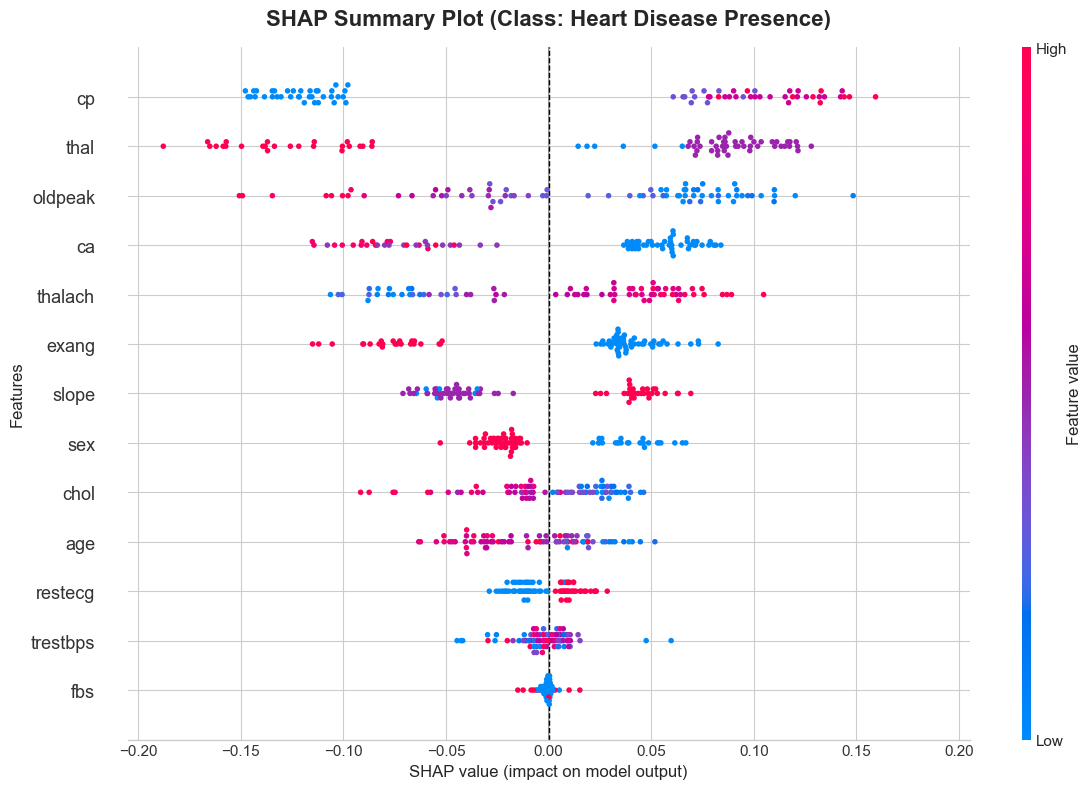

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))

shap_values_pos = shap_values[:, :, 1]

shap.summary_plot(
    shap_values_pos,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()

ax.axvline(0, color="black", linestyle="--", linewidth=1)
max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)

plt.title(
    "SHAP Summary Plot (Class: Heart Disease Presence)",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()


## LIME

In [11]:
#LIME setup

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["malignant", "benign"],
    discretize_continuous=True,
    mode="classification"
)

index = 0
instance = X_test.iloc[index]

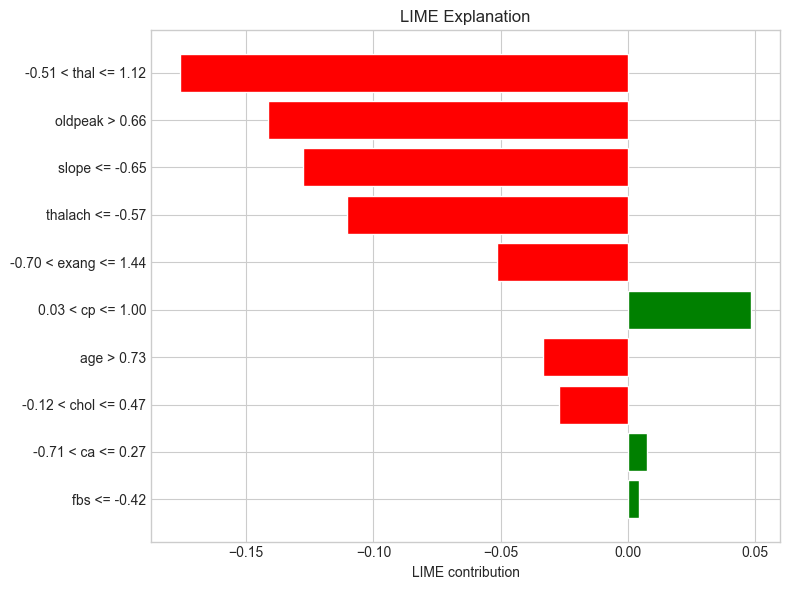

In [12]:
def predict_proba_pipeline(x):
    x_df = pd.DataFrame(x, columns=X.columns)
    return best_model.predict_proba(x_df)

lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_pipeline,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Counterfactual Explanations (DiCE)

In [13]:
#DiCE setup

df = X.copy()
df["target"] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=X.columns.tolist(),
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = instance.to_frame().T

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

cf = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=0
)


100%|██████████| 1/1 [01:12<00:00, 72.32s/it]


In [15]:
cf_df = cf.cf_examples_list[0].final_cfs_df
original = query_instance.iloc[0]
diff = cf_df[X.columns] - original[X.columns]
diff_changed = diff.loc[:, (diff != 0).any(axis=0)]

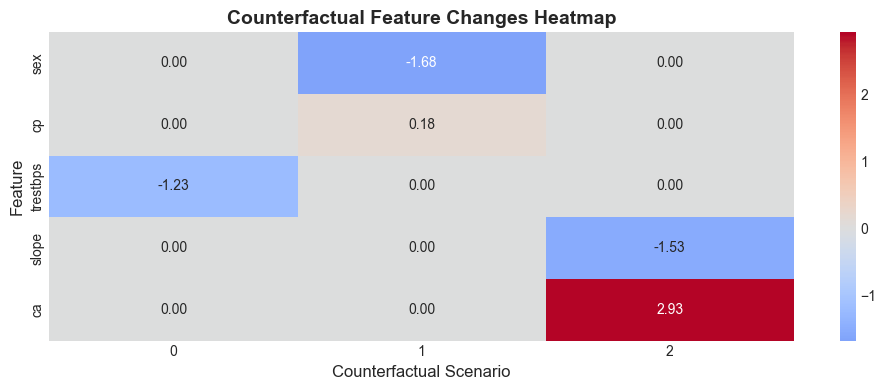

In [16]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

----

## Evaluation

#### VALIDITY

In [17]:
desired_class = 0
cf_features = cf_df[X.columns]
cf_preds = best_model.predict(cf_features)
orig = query_instance.iloc[0][X.columns]
cf_X = cf_features
l1_distance = (cf_X - orig).abs().sum(axis=1)

In [18]:
validity = cf_preds == desired_class

validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_preds))],
    "Predicted class": cf_preds,
    "Valid (prediction flipped)": validity
})

validity_df


,Counterfactual,Predicted class,Valid (prediction flipped)
0,CF_0,0,True
1,CF_1,0,True
2,CF_2,0,True


#### SPARSITY

In [19]:
sparsity = (cf_X != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(sparsity))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df


,Counterfactual,Sparsity (number of features changed)
0,CF_0,1
1,CF_1,2
2,CF_2,2


#### PROXIMITY


In [20]:
proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df


,Counterfactual,Proximity (L1 distance)
0,CF_0,1.225152
1,CF_1,1.860644
2,CF_2,4.456794


#### PLAUSIBILITY

In [21]:
def plausible(cf_row, X):
    return ((cf_row >= X.min()) & (cf_row <= X.max())).all()

plausibility = cf_features.apply(lambda row: plausible(row, X), axis=1)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df

,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True


----